In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from scipy import stats

from scipy import interpolate

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from cinplaAnalysis.utils import *

%matplotlib ipympl

In [2]:
from cinplaAnalysis.icsd import StandardCSD, DeltaiCSD, StepiCSD

In [3]:
import matplotlib

font = {'size'   : 12}

matplotlib.rc('font', **font)

In [4]:
matplotlib.rcParams['savefig.pad_inches'] = 0

In [5]:
def plotFig(ax,csd,breaks=None,absmax=None,timeLimited=False,plotCB=False,xlabels=False,title=None):

    if breaks is not None:
        for b in breaks:
            ax.plot([0,3000],[b,b],c='k')

    if absmax is None:
        absmax = np.max(np.abs(csd))

    rms = np.mean(np.sqrt(csd**2))
    
    im = ax.imshow(np.array(csd)/rms, origin='lower',cmap='bwr_r',vmin=-10,vmax=10)#, vmin =-absmax,vmax=absmax, cmap='bwr_r')
    ax.axis(ax.axis('tight'))

    if plotCB:
        cb = plt.colorbar(im, ax=ax)
        cb.formatter.set_powerlimits((0,0))


    ax.set_yticklabels([])

    if xlabels:
        ax.set_xticks([2000,2050],labels=['0','50'])
        # ax.set_xlabel('Time (ms)')
    else:
        ax.set_xticklabels([])

    if timeLimited:
        ax.set_xlim([50,100])
    else:
        ax.set_xlim([2000,2050])

    if title:
        plt.title(title)

    plt.tight_layout()

In [6]:
highRes = np.load('highRes/total.npy') # Loads LFP and oCSD averaged over trials, 20 um spacing, rho=500um

lfpIdx = np.arange(101) 

totalLFPHighRes = highRes[:,lfpIdx] # LFP, 20 um spacing
totalLFPLowRes = totalLFPHighRes[:,0:totalLFPHighRes.shape[1]:2] # LFP, 40 um spacing
totalLFPLowResHalf = totalLFPHighRes[:,0:totalLFPHighRes.shape[1]:4] # LFP, 80 um spacing
totalLFPLowResQuarter = totalLFPHighRes[:,0:totalLFPHighRes.shape[1]:8] # LFP, 160 um spacing

disk_fullDensity_idx = np.arange(202,303)
objective_disk_full_highRes = highRes[:,disk_fullDensity_idx] # oCSD, 20 um spacing



In [7]:
highRes.shape

(3000, 304)

In [8]:
from scipy.signal import *
sos = butter(10, [1,499], 'bp', fs=1000, output='sos')

totalLFPHighRes = sosfilt(sos, totalLFPHighRes,axis=0)
totalLFPLowRes = sosfilt(sos, totalLFPLowRes,axis=0)
totalLFPLowResHalf = sosfilt(sos, totalLFPLowResHalf,axis=0)
totalLFPLowResQuarter = sosfilt(sos, totalLFPLowResQuarter,axis=0)

In [9]:
### Calculates oCSD for 40, 80, and 160 um electrode spacing, with rho of 500 um, by taking the sum of neighboring electrodes in the 20 um case

objective_disk_full_lowRes = np.zeros_like(totalLFPLowRes)
objective_disk_half_lowRes = np.zeros_like(totalLFPLowResHalf)
objective_disk_quarter_lowRes = np.zeros_like(totalLFPLowResQuarter)

for l in range(objective_disk_full_lowRes.shape[1]):
    if l == 0:
        objective_disk_full_lowRes[:,l] = objective_disk_full_highRes[:,2*l]+.5*objective_disk_full_highRes[:,2*l+1]
    elif l == objective_disk_full_lowRes.shape[1]-1:
        objective_disk_full_lowRes[:,l] = objective_disk_full_highRes[:,2*l]+.5*objective_disk_full_highRes[:,2*l-1]
    else:
        objective_disk_full_lowRes[:,l] = objective_disk_full_highRes[:,2*l]+.5*objective_disk_full_highRes[:,2*l-1]+.5*objective_disk_full_highRes[:,2*l+1]

for l in range(objective_disk_half_lowRes.shape[1]):
    if l == 0:
        objective_disk_half_lowRes[:,l] = objective_disk_full_lowRes[:,2*l]+.5*objective_disk_full_lowRes[:,2*l+1]
    elif l == objective_disk_half_lowRes.shape[1]-1:
        objective_disk_half_lowRes[:,l] = objective_disk_full_lowRes[:,2*l]+.5*objective_disk_full_lowRes[:,2*l-1]
    else:
        objective_disk_half_lowRes[:,l] = objective_disk_full_lowRes[:,2*l]+.5*objective_disk_full_lowRes[:,2*l-1]+.5*objective_disk_full_lowRes[:,2*l+1]

for l in range(objective_disk_quarter_lowRes.shape[1]):
    if l == 0:
        objective_disk_quarter_lowRes[:,l] = objective_disk_half_lowRes[:,2*l]+.5*objective_disk_half_lowRes[:,2*l+1]
    elif l == objective_disk_quarter_lowRes.shape[1]-1:
        objective_disk_quarter_lowRes[:,l] = objective_disk_half_lowRes[:,2*l]+.5*objective_disk_half_lowRes[:,2*l-1]
    else:
        objective_disk_quarter_lowRes[:,l] = objective_disk_half_lowRes[:,2*l]+.5*objective_disk_half_lowRes[:,2*l-1]+.5*objective_disk_half_lowRes[:,2*l+1]


In [10]:
### Calculates iCSD and standard CSD

diam = 500E-6 * pq.m                              # [m]
sigma = 0.376 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
sigma_top = 0.376 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]

# Input dictionaries for each method

step_input_high = {
    'lfp' : totalLFPHighRes.T * pq.V,   # [mV] -> [V],
    'coord_electrode' : 20 * np.arange(0,101) * 1e-6 * pq.m,
    'sigma' : sigma,
    'h':20E-6 * pq.m ,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
    'diam': diam
}

step_input_low = {
    'lfp' : totalLFPLowRes.T  * pq.V,      # [mV] -> [V],
    'coord_electrode' : 40 * np.arange(0,51) * 1e-6 * pq.m,
    'sigma' : sigma,
    'h':40E-6 * pq.m ,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
    'diam': diam
}

step_input_low_half = {
    'lfp' : totalLFPLowResHalf.T  * pq.V,      # [mV] -> [V],
    'coord_electrode' : 80 * np.arange(0,totalLFPLowResHalf.shape[1]) * 1e-6 * pq.m,
    'sigma' : sigma,
    'h':80E-6 * pq.m ,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
    'diam': diam
}

step_input_low_quarter = {
    'lfp' : totalLFPLowResQuarter.T  * pq.V,      # [mV] -> [V],
    'coord_electrode' : 160 * np.arange(0,totalLFPLowResQuarter.shape[1]) * 1e-6 * pq.m,
    'sigma' : sigma,
    'h':160E-6 * pq.m ,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
    'diam': diam
}

std_input_high = {
    'lfp' : totalLFPHighRes.T * pq.V,   # [mV] -> [V],
    'coord_electrode' : 20 * np.arange(0,101) * 1e-6 * pq.m,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1)
}

std_input_low = {
    'lfp' : totalLFPLowRes.T * pq.V,      # [mV] -> [V],
    'coord_electrode' : 40 * np.arange(0,51) * 1e-6 * pq.m,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1)
}

std_input_low_half = {
    'lfp' : totalLFPLowResHalf.T * pq.V,      # [mV] -> [V],
    'coord_electrode' : 80 * np.arange(0,totalLFPLowResHalf.shape[1]) * 1e-6 * pq.m,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1)
}

std_input_low_quarter = {
    'lfp' : totalLFPLowResQuarter.T * pq.V,      # [mV] -> [V],
    'coord_electrode' : 160 * np.arange(0,totalLFPLowResQuarter.shape[1]) * 1e-6 * pq.m,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1)
}


icsd_high = StepiCSD(**step_input_high)
icsd_low = StepiCSD(**step_input_low)
icsd_low_half = StepiCSD(**step_input_low_half)
icsd_low_quarter = StepiCSD(**step_input_low_quarter)

icsd_high_std = StandardCSD(**std_input_high)
icsd_low_std = StandardCSD(**std_input_low)
icsd_low_half_std = StandardCSD(**std_input_low_half)
icsd_low_quarter_std = StandardCSD(**std_input_low_quarter)
        

In [11]:
max_LFP_magnitude = np.max(np.max(totalLFPLowResQuarter[2000:2050],axis=0) - np.min(totalLFPLowResQuarter[2000:2050],axis=0))
print(max_LFP_magnitude)

0.00017780077772605403


In [12]:
np.min(totalLFPLowResQuarter[2000:2050])

-0.00013844330933135467

In [13]:
truecsd = icsd_low_quarter.get_csd()[:,2000:2050]

In [14]:
truecsd.shape

(13, 50)

In [15]:
np.max(np.abs(truecsd))

array(4336.3153349) * A/m**3

In [16]:
peak_csd_timepoint = np.where(np.abs(truecsd)==np.max(np.abs(truecsd)))[1]

In [17]:
peak_csd_timepoint

array([14])

In [24]:
np.min(truecsd)*pq.uA/pq.A*pq.m**3/pq.mm**3

array(-4336.3153349) * uA/mm**3

In [25]:
# Dipole density estimated directly from CSD in the dipole paper, for full-whisker stimulus
np.sum(np.array([0.1,0.4,0.5,0.8,1.2,1.3,1.6,1.7,2])*pq.mm*np.array([0.3,0.1,0.1,0.2,.1,.1,.1,.1,.2])*pq.mm*np.array([5,-3,-4,-4,1,-1,1,2,3])*pq.uA/pq.mm**3).simplified


array(0.00088) * A/m

In [26]:
# Dipole from this density, assuming full barrel cortex has 10 mm^2 area
(0.00088 * pq.A/pq.m * 10*pq.mm**2).simplified

array(8.8e-09) * m*A

In [27]:
np.argmin(truecsd)

464

In [28]:
np.where(truecsd==np.min(truecsd))

(array([9]), array([14]))

In [19]:
distances = 160 * np.arange(0,totalLFPLowResQuarter.shape[1]) * 1e-6 * pq.m

In [20]:
distances

array([0.     , 0.00016, 0.00032, 0.00048, 0.00064, 0.0008 , 0.00096,
       0.00112, 0.00128, 0.00144, 0.0016 , 0.00176, 0.00192]) * m

In [21]:
np.pi*(250e-3*pq.mm)**2

array(0.19634954) * mm**2

In [22]:
# Total dipole from a given area assuming the dipole density in the paper
(np.pi*(400*pq.m*1e-6)**2*2e-9*pq.A*pq.m/pq.mm**2).simplified

array(1.00530965e-09) * m*A

In [23]:
# Signal from the dipole in the cell above, assuming an E-field calculated from the compartment weights in our paper
1e-9*pq.A*pq.m * 5*pq.V/pq.A/(1e-3*pq.m)

array(5.e-06) * V

In [24]:
# Total dipole from full SSCx area assuming the dipole density in the paper
(40*pq.mm**2*2e-9*pq.A*pq.m/pq.mm**2).simplified

array(8.e-08) * m*A

In [25]:
# Signal from the dipole in the cell above, assuming an E-field calculated from the compartment weights in our paper
1e-7*pq.A*pq.m * 5*pq.V/pq.A/(1e-3*pq.m)

array(0.0005) * V

In [26]:
(0.00016*pq.A/pq.m).rescale(pq.nA*pq.m/pq.mm**2)

array(0.16) * m*nA/mm**2

In [31]:
distances

array([0.     , 0.00016, 0.00032, 0.00048, 0.00064, 0.0008 , 0.00096,
       0.00112, 0.00128, 0.00144, 0.0016 , 0.00176, 0.00192]) * m

In [30]:
np.sum((distances) *truecsd[:,14]*160*pq.m*1e-6)


array(-0.00026579) * A/m

In [28]:
# Estimates the dipole density from the CSD, under the assumption that LFP comes from a single column
np.sum((distances) *truecsd[:,14]*160*pq.m*1e-6)
# = 0.2 nA m /mm^2

array(-0.00026579) * A/m

In [177]:
# Estimates the dipole from that dipole density above, given a 1-column radius
(0.2*pq.nA*pq.m/pq.mm**2*np.pi*(200*pq.m*1e-6)**2).simplified

array(2.51327412e-11) * m*A

In [179]:
# EEG from a 1-column dipole, assumping peak field strength
2.5e-11 * pq.A *pq.m * 5*pq.V/pq.A/(1.5e-3*pq.m)

array(8.33333333e-08) * V

In [169]:
# Estimates the dipole from that dipole density above, given a certain assumed radius
(0.3*pq.nA*pq.m/pq.mm**2*np.pi*(400*pq.m*1e-6)**2).simplified

array(1.50796447e-10) * m*A

In [170]:
# Calculates the signal from the dipole above, assuming an E field calculated from the compartment weights in our paper
1.5e-10 * pq.A * pq.m * 3*pq.V/pq.A/(1e-3*pq.m)

array(4.5e-07) * V

In [95]:
# Calculates the signal from the dipole above, assuming a smaller E field than that calculated from the compartment weights in our paper
1e-10 * pq.A * pq.m * 3*pq.V/pq.A/(1e-3*pq.m)

array(3.e-07) * V

In [182]:
# Estimates the dipole from the CSD, assuming a fill-sscx radius
np.sum((distances) *truecsd[:,14]*40*pq.mm**2*160*pq.m*1e-6).simplified

array(-1.06314067e-08) * m*A

In [101]:
# Calculates the signal from the dipole above, assuming a smaller E field than that calculated from the compartment weights in our paper
1e-8 * pq.A * pq.m * 3*pq.V/pq.A/(1e-3*pq.m)

array(3.e-05) * V

In [103]:
# Calculates area needed for our csd to produce the 0.4 nAm dipole magnitude from the other paper: 2 mm^2
print(np.sum((distances) *truecsd[:,13]*2*pq.mm**2*160*pq.m*1e-6).simplified)
print(2*pq.mm**2/(np.pi*(200*pq.mm*1e-3)**2))

array(-3.74087966e-10) * m*A

In [109]:
# Calculates the signal from the original dipole (rather than the dipole density) in the paper
(0.4e-9 * pq.A * pq.m * 3*pq.V/pq.A/(1e-3*pq.m))

array(1.2e-06) * V

In [22]:
5*pq.V/pq.A/(1e-3*pq.m)

array(5000.) * V/(m*A)

In [23]:
3*pq.V/pq.m/(400e-6*pq.A)

array(7500.) * V/(m*A)

In [24]:
7 * pq.A * pq.m * 5*pq.V/pq.A/(.5e-3*pq.m)

array(70000.) * V

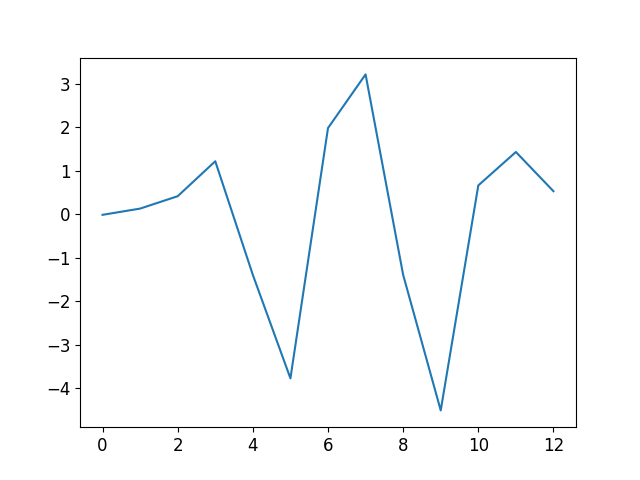

In [99]:
plt.figure()
plt.plot(truecsd[:,13])

In [101]:
7*pq.A/pq.m**3 * np.pi*(400*pq.m*1e-6)**2*160*pq.m * 160*pq.m*1e-6*2 * 5*pq.V/pq.A/(1e-3*pq.m)

array(0.00090076) * V

In [74]:
(5 * pq.mV /pq.mm**2 * 0.3 * pq.S/pq.m).simplified * np.pi*(400*pq.m*1e-6)**2 * (250*pq.m*1e-6)**2 * 5*pq.V/pq.A/(.5e-3*pq.m)

array(4.71238898e-07) * V

In [11]:
np.min(totalLFPLowRes)

-0.0005928966884092123

In [17]:
np.max(truecsd)

array(5.52850224) * A/m**3

In [13]:
np.max(truecsd)*np.pi*(250*pq.m*1e-6)**2*500*pq.m*1e-6*1000*pq.m*1e-6

array(5.42759438e-13) * m*A

In [29]:
((6*pq.cm)**2/(750*pq.m*1e-6)**2).simplified*58e-9*pq.V

array(0.0003712) * V

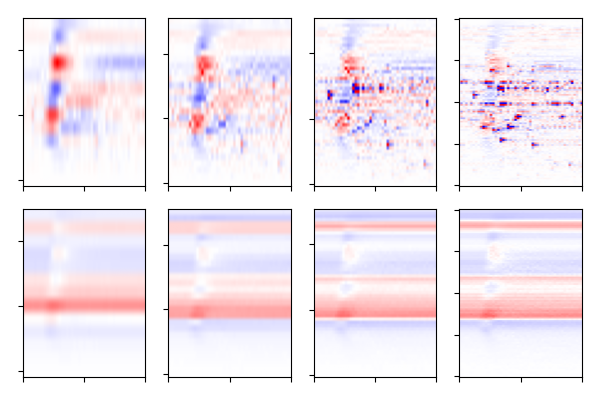

In [13]:
### Plots Figure 2a

fig, axes = plt.subplots(2,4,figsize=(6,4))

plotFig(axes[0][0],icsd_low_quarter.get_csd())
plotFig(axes[1][0],objective_disk_quarter_lowRes.T)

plotFig(axes[0][1],icsd_low_half.get_csd())
plotFig(axes[1][1],objective_disk_half_lowRes.T)

plotFig(axes[0][2],icsd_low.get_csd())
plotFig(axes[1][2],objective_disk_full_lowRes.T)

plotFig(axes[0][3],icsd_high.get_csd())
plotFig(axes[1][3],objective_disk_full_highRes.T)

#plt.savefig('figures/csds.png',dpi=600)


FileNotFoundError: [Errno 2] No such file or directory: 'figures/csds_std.png'

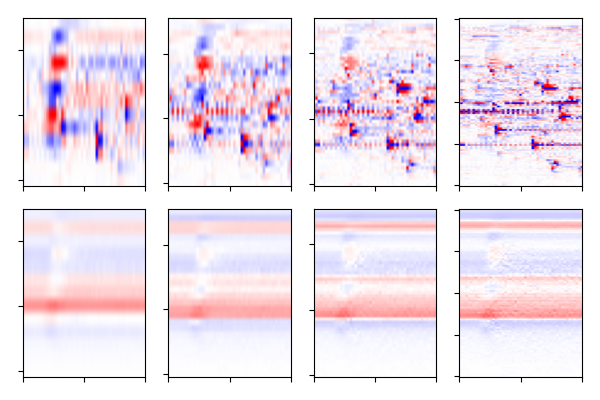

In [14]:
### Plots the equivalent of Figure 2a, but for standard CSD instead of iCSD. Not used in the paper

fig, axes = plt.subplots(2,4,figsize=(6,4))

plotFig(axes[0][0],icsd_low_quarter_std.get_csd())
plotFig(axes[1][0],objective_disk_quarter_lowRes.T)

plotFig(axes[0][1],icsd_low_half_std.get_csd())
plotFig(axes[1][1],objective_disk_half_lowRes.T)

plotFig(axes[0][2],icsd_low_std.get_csd())
plotFig(axes[1][2],objective_disk_full_lowRes.T)

plotFig(axes[0][3],icsd_high_std.get_csd())
plotFig(axes[1][3],objective_disk_full_highRes.T)

plt.savefig('figures/csds_std.png',dpi=600)

In [25]:
### Calculates correlations between iCSD and oCSD for all electrode spacings

correlations_high_stim = []
correlations_low_stim = []
correlations_low_half_stim = []
correlations_low_quarter_stim = []

for i in np.arange(2000,2050):
    correlations_high_stim.append(np.corrcoef(icsd_high.get_csd()[:,i],objective_disk_full_highRes.T[:,i])[0,1])
    correlations_low_stim.append(np.corrcoef(icsd_low.get_csd()[:,i],objective_disk_full_lowRes.T[:,i])[0,1])
    correlations_low_half_stim.append(np.corrcoef(icsd_low_half.get_csd()[:,i],objective_disk_half_lowRes.T[:,i])[0,1])
    correlations_low_quarter_stim.append(np.corrcoef(icsd_low_quarter.get_csd()[:,i],objective_disk_quarter_lowRes.T[:,i])[0,1])


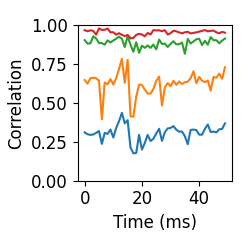

In [27]:
### Plots Figure 2b

plt.figure(figsize=(2.5,2.5))
plt.plot(correlations_high_stim,c='C0')
plt.plot(correlations_low_stim,c='C1')
plt.plot(correlations_low_half_stim,c='C2')
plt.plot(correlations_low_quarter_stim,c='C3')

plt.ylim([0,1])
plt.xlabel('Time (ms)')
plt.ylabel('Correlation')
plt.tight_layout()
plt.savefig('figures/correlations.png',dpi=300)

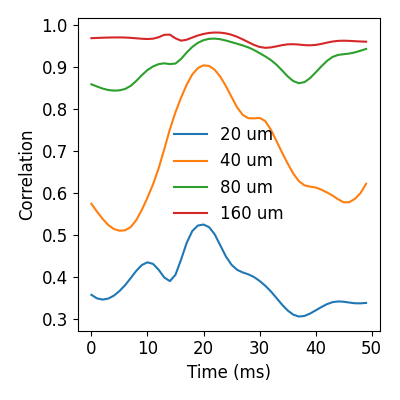

In [25]:
### Plots Figure 2b again, but with a legend

plt.figure(figsize=(4,4))
plt.plot(correlations_high_stim,c='C0',linestyle=None)
plt.plot(correlations_low_stim,c='C1',linestyle=None)
plt.plot(correlations_low_half_stim,c='C2',linestyle=None)
plt.plot(correlations_low_quarter_stim,c='C3',linestyle=None)

# plt.plot(correlations_high_rest,'--',c='C0')
# plt.plot(correlations_low_rest,'--',c='C1')
# plt.plot(correlations_low_half_rest,'--',c='C2')
# plt.plot(correlations_low_quarter_rest,'--',c='C3')

plt.legend(['20 um', '40 um','80 um','160 um'],framealpha=0)
plt.xlabel('Time (ms)')
plt.ylabel('Correlation')
plt.tight_layout()
plt.savefig('figures/correlations_legend.png',dpi=300)